# Diamond Price Prediction

## Data reference: 

Diamond Price Prediction (https://www.kaggle.com/datasets/ritikmaheshwari/diamond-price-prediction/data?select=Diamond_Price_Prediction.ipynb)

## About the dataset

* Data description: The dataset describes the physical and qualitative characteristics of diamonds, including features such as carat weight, cut, color, clarity, depth, table,  and price, which has 53,940 observations and 10 variables.

* The ML problem: How to predict a diamond’s price based on its physical and qualitative characteristics?

## Variable Description

### Original Variables:

* price: The price of the Diamond
* carat: The carat value of the Diamond
* cut: The cut type of the Diamond, it determines the shine
* color: The color value of the Diamond
* clarity: The carat type of the Diamond
* depth: The ratio of a diamond's overall height to its average diameter (expressed as a percentage).
* table: The ratio of the width of the largest flat surface at the top of the diamond (called the "table facet") to the widest part of the diamond.
* x: Width of the diamond
* y: Length of the diamond
* z: Height of the diamond

### The variable I add:

* volume: The volume of a diamond, which is equal to the product of length, width, and height (in the dataset is x*y*z)
* density: Density = carat / volumn. 
* xy_radio: This value measures whether a diamond is close to a perfect circle. The closer the value to 1, the closer the diamond is a perfect circle.

## Data preprocessing

### Import:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import logging
# from collections import OrderedDict
# from sklearn.ensemble import BaggingRegressor
# from sklearn.tree import DecisionTreeClassifier
# %pip install optuna optuna-dashboard

In [3]:
# base modules
from pathlib import Path
from scipy import stats

# for manipulating data
import numpy as np
import pandas as pd
import math
import scipy
import seaborn as sns
import optuna
import copy

# for Machine Learning
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from scipy.cluster import hierarchy

# for visualization
from matplotlib import pyplot as plt

In [4]:
path_to_repo = Path('..').resolve()
path_to_data = path_to_repo / 'data'

### Data analysis

In [5]:
df_raw = pd.read_csv(path_to_data / 'diamonds_data.csv')

In [6]:
df_raw = df_raw.convert_dtypes()

In [7]:
df_raw.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.2,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [8]:
df_raw.shape

(53940, 10)

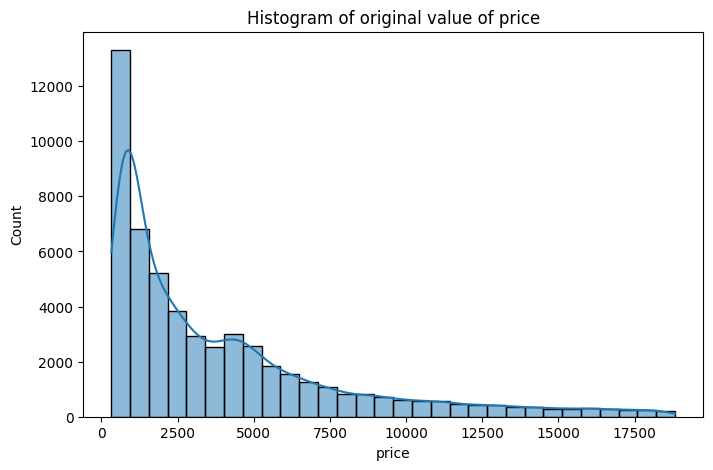

In [9]:
plt.figure(figsize=(8,5))
sns.histplot(df_raw['price'], bins=30, kde=True) 
plt.title("Histogram of original value of price")
plt.xlabel("price")
plt.ylabel("Count")
plt.show()

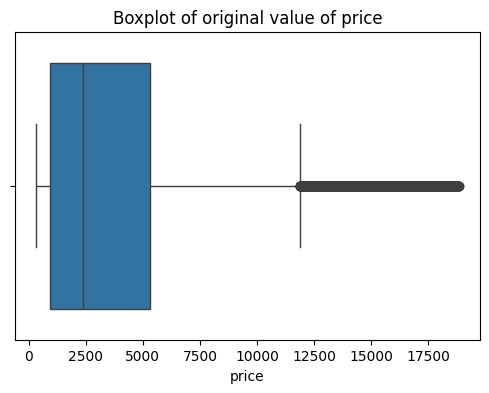

In [10]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df_raw['price'])
plt.title("Boxplot of original value of price")
plt.xlabel("price")
plt.show()

### Data clean

In [11]:
df_new = df_raw[(df_raw[['x', 'y', 'z']] != 0).all(axis=1)]

In [12]:
df_new.shape

(53920, 10)

In [13]:
df_new['volume'] = df_new['x'] * df_new['y'] * df_new['z']
df_new['density'] = df_new['carat'] / df_new['volume']
df_new['xy_ratio'] = df_new['x'] / df_new['y']

C:\Users\13983\AppData\Local\Temp\ipykernel_21252\1780417810.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['volume'] = df_new['x'] * df_new['y'] * df_new['z']
C:\Users\13983\AppData\Local\Temp\ipykernel_21252\1780417810.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['density'] = df_new['carat'] / df_new['volume']
C:\Users\13983\AppData\Local\Temp\ipykernel_21252\1780417810.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [14]:
df_new

,carat,cut,color,clarity,depth,table,price,x,y,z,volume,density,xy_ratio
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,38.20203,0.006021,0.992462
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,34.505856,0.006086,1.013021
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,38.076885,0.00604,0.995086
3,0.29,Premium,I,VS2,62.4,58.0,334,4.2,4.23,2.63,46.72458,0.006207,0.992908
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,51.91725,0.005971,0.997701
...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.5,115.92,0.006211,0.998264
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61,118.110175,0.006096,0.989565
53937,0.7,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56,114.449728,0.006116,0.996479
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74,140.76612,0.006109,1.004902


In [15]:
df_new.isnull().sum().sum()

np.int64(0)

In [16]:
z_scores = np.abs(stats.zscore(df_new['price'], nan_policy='omit'))
df_new = df_new[z_scores < 2.5]

In [17]:
df_new['cut'].unique()

<StringArray>
['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']
Length: 5, dtype: string

In [18]:
df_new['color'].unique()

<StringArray>
['E', 'I', 'J', 'H', 'F', 'G', 'D']
Length: 7, dtype: string

In [19]:
df_new['clarity'].unique()

<StringArray>
['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']
Length: 8, dtype: string

In [20]:
diamond_maps = {
    'cut': {
        'Fair': 1,
        'Good': 2,
        'Very Good': 3,
        'Premium': 4,
        'Ideal': 5
    },
    'color': {
        'J': 1,
        'I': 2,
        'H': 3,
        'G': 4,
        'F': 5,
        'E': 6,
        'D': 7
    },
    'clarity': {
        'I1': 1,
        'SI2': 2,
        'SI1': 3,
        'VS2': 4,
        'VS1': 5,
        'VVS2': 6,
        'VVS1': 7,
        'IF': 8
    }
}

In [21]:
def process(df: pd.DataFrame, y_field: str, custom_maps: dict):
    df = copy.deepcopy(df)
    
    y = df[y_field].values
    df = df.drop(columns=[y_field])
    
    for col_name, mapping_dict in custom_maps.items():
        if col_name in df.columns:
            df[col_name] = df[col_name].map(mapping_dict)

    return df, y

In [22]:
df, y = process(df_new, y_field = 'price',custom_maps = diamond_maps)

In [23]:
type(df)

pandas.core.frame.DataFrame

In [24]:
df.to_csv(path_to_data / 'processed.csv', index = False)

In [25]:
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,volume,density,xy_ratio
0,0.23,5,6,2,61.5,55.0,3.95,3.98,2.43,38.20203,0.006021,0.992462
1,0.21,4,6,3,59.8,61.0,3.89,3.84,2.31,34.505856,0.006086,1.013021
2,0.23,2,6,5,56.9,65.0,4.05,4.07,2.31,38.076885,0.00604,0.995086
3,0.29,4,2,4,62.4,58.0,4.2,4.23,2.63,46.72458,0.006207,0.992908
4,0.31,2,1,2,63.3,58.0,4.34,4.35,2.75,51.91725,0.005971,0.997701


Take the logarithm of the target variable price :

In [26]:
y = np.log(y)

In [27]:
y

<FloatingArray>
[ 5.786897381366708,  5.786897381366708, 5.7899601708972535,
  5.811140992976701,  5.814130531825066,  5.817111159963204,
  5.817111159963204,  5.820082930352362,  5.820082930352362,
  5.823045895483019,
 ...
 7.9215356321335495, 7.9215356321335495,  7.921898411023797,
  7.921898411023797,  7.921898411023797,  7.921898411023797,
  7.921898411023797,  7.921898411023797,  7.921898411023797,
  7.921898411023797]
Length: 51709, dtype: Float64

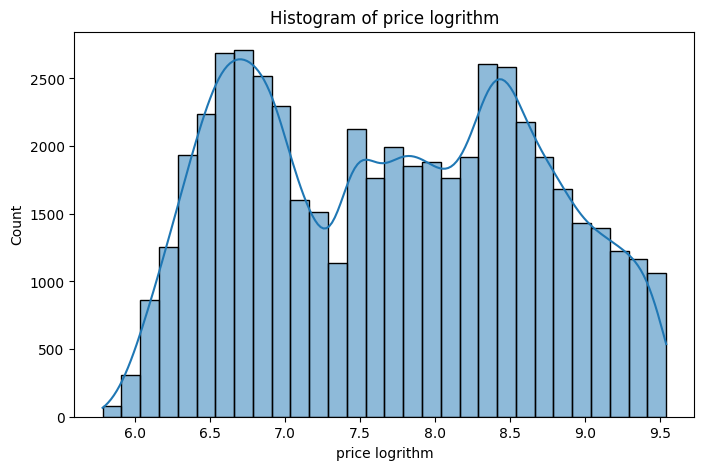

In [28]:
plt.figure(figsize=(8,5))
sns.histplot(y, bins=30, kde=True) 
plt.title("Histogram of price logrithm")
plt.xlabel("price logrithm")
plt.ylabel("Count")
plt.show()

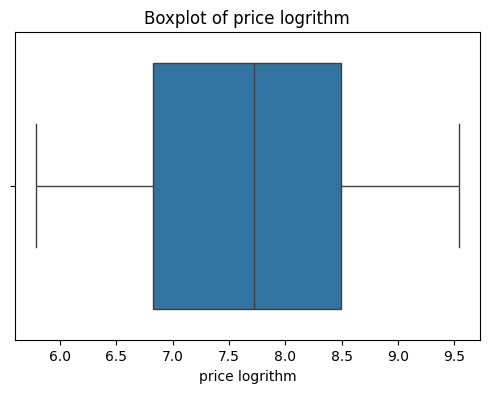

In [29]:
plt.figure(figsize=(6,4))
sns.boxplot(x= y)
plt.title("Boxplot of price logrithm")
plt.xlabel("price logrithm")
plt.show()

## Model 1 -- Random Forest Regression

Split into training dataset and validation dataset randomly

In [30]:
X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size=15000, random_state=42)

Choose RMSE as the evaluation metric

In [31]:
def rmse(y_true, y_pred): 
    return math.sqrt(((y_true - y_pred)**2).mean())

In [32]:
def print_score(m, X_train, y_train, X_valid, y_valid):
    print('RMSE on train set: {:.4f}'.format(rmse(m.predict(X_train), y_train)))
    print('RMSE on valid set: {:.4f}'.format(rmse(m.predict(X_valid), y_valid)))
    print('R^2 on train set: {:.4f}'.format(m.score(X_train, y_train)))
    print('R^2 on valid set: {:.4f}'.format(m.score(X_valid, y_valid)))
    if hasattr(m, 'oob_score_'): print('R^2 on oob set: {:.4f}'.format(m.oob_score_))
    return

Decision Tree Regressor

In [33]:
model_dt = DecisionTreeRegressor(
    criterion = 'squared_error',
    splitter = 'best', 
    max_depth = 5,
    min_samples_split = 3, 
    min_samples_leaf = 3,
    min_weight_fraction_leaf = 0.0, 
    max_features = None, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0,
    random_state = 42, 
)

In [34]:
%time model_dt.fit(X_train, y_train)
print_score(model_dt, X_train, y_train, X_valid, y_valid)

CPU times: total: 78.1 ms
Wall time: 141 ms
RMSE on train set: 0.1896
RMSE on valid set: 0.1917
R^2 on train set: 0.9607
R^2 on valid set: 0.9593


Random Forest Regressor

In [35]:
model_rf = RandomForestRegressor(
    n_estimators = 10,

    criterion = 'squared_error',
    max_depth = 5,
    min_samples_split = 3, 
    min_samples_leaf = 3,
    min_weight_fraction_leaf = 0.0, 
    max_features = None, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0,
    random_state = 42,
    
    bootstrap = True, 
    oob_score = True, 
    max_samples = 0.3,

    warm_start = False, 
    n_jobs = -1,
    verbose = 0, 
)

In [36]:
model_rf.fit(X_train, y_train)
print_score(model_rf, X_train, y_train, X_valid, y_valid)

RMSE on train set: 0.1721
RMSE on valid set: 0.1724
R^2 on train set: 0.9677
R^2 on valid set: 0.9671
R^2 on oob set: 0.9668


In [ ]:
def objective(trial, X_train, y_train, X_valid, y_valid):
    """
    This function estimates a trial quality.
    It contains the 4 steps : hp sampling, model definition, training and evaluation.
    
    Parameters:
    ----------
    trial (optuna.trial.Trial): the trial at stake
    X_training: pd.DataFrame. Table containing features used for training.
    X_validation: pd.DataFrame. Table containing features used for validation.
    y_training: array-like. List of true target variable values for training.
    y_validation: array-like. List of true target variable values for validation.

    Returns:
    -------
    float: performance metric value (R^2)
    """
    
    max_depth_guess = trial.suggest_int("max_depth", 5, 100, log=False)
    min_sample_guess = trial.suggest_int("min_samples_split", 5, 20, log=False)
    estimator_guess = trial.suggest_int("n_estimators", 10, 100, log=False)
    
    model_rf = RandomForestRegressor(
        n_estimators = estimator_guess,
        criterion = 'squared_error',
        max_depth = max_depth_guess,
        min_samples_split = min_sample_guess, 
        min_samples_leaf = 5,
        min_weight_fraction_leaf = 0.0, 
        max_features = None, 
        max_leaf_nodes = None, 
        min_impurity_decrease = 0.0, 
        ccp_alpha = 0.0,
        random_state = 42,
    
        bootstrap = True, 
        oob_score = True, 
        max_samples = 0.3,

        warm_start = False, 
        n_jobs = -1,
        verbose = 0,           
    )
    
    model_rf.fit(X_train, y_train)
    
    y_pred_validation = model_rf.predict(X_valid)
    r2_validation = metrics.r2_score(y_valid, y_pred_validation)
    return r2_validation

In [38]:
study = optuna.create_study(study_name="ram_opt", 
                            load_if_exists=True, 
                            storage = "sqlite:///ram.db",
                            direction="maximize")

study.optimize(lambda trial: objective(trial, X_train, y_train, X_valid, y_valid), n_trials=100, show_progress_bar=True)

[I 2025-12-07 12:22:00,115] Using an existing study with name 'ram_opt' instead of creating a new one.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-07 12:22:01,581] Trial 521 finished with value: 0.9911380764751256 and parameters: {'max_depth': 72, 'min_samples_split': 9, 'n_estimators': 81}. Best is trial 466 with value: 0.9914165489634807.
[I 2025-12-07 12:22:02,765] Trial 522 finished with value: 0.9911389564193331 and parameters: {'max_depth': 77, 'min_samples_split': 9, 'n_estimators': 76}. Best is trial 466 with value: 0.9914165489634807.
[I 2025-12-07 12:22:03,946] Trial 523 finished with value: 0.9911411856877507 and parameters: {'max_depth': 72, 'min_samples_split': 9, 'n_estimators': 80}. Best is trial 466 with value: 0.9914165489634807.
[I 2025-12-07 12:22:05,324] Trial 524 finished with value: 0.9911380764751256 and parameters: {'max_depth': 74, 'min_samples_split': 9, 'n_estimators': 81}. Best is trial 466 with value: 0.9914165489634807.
[I 2025-12-07 12:22:06,720] Trial 525 finished with value: 0.9911381781871502 and parameters: {'max_depth': 71, 'min_samples_split': 9, 'n_estimators': 78}. Best is trial 4

In [39]:
study.best_params

{'max_depth': 68, 'min_samples_split': 10, 'n_estimators': 84}

In [40]:
model_rf = RandomForestRegressor(
    n_estimators = 84,

    criterion = 'squared_error',
    max_depth = 68,
    min_samples_split = 10, 
    min_samples_leaf = 5,
    min_weight_fraction_leaf = 0.0, 
    max_features = 92, 
    max_leaf_nodes = None, 
    min_impurity_decrease = 0.0, 
    ccp_alpha = 0.0,
    random_state = 42,
    
    bootstrap = True, 
    oob_score = True, 
    max_samples = 0.3,

    warm_start = False, 
    n_jobs = -1,
    verbose = 0,
) 

In [41]:
model_rf.fit(X_train, y_train)
print_score(model_rf, X_train, y_train, X_valid, y_valid)

RMSE on train set: 0.0778
RMSE on valid set: 0.0895
R^2 on train set: 0.9934
R^2 on valid set: 0.9911
R^2 on oob set: 0.9913


In [42]:
scores = cross_val_score(model_rf, X_train, y_train, cv = 8, n_jobs = -1)

print(scores)
print("r2 is {:.3f} with a standard deviation of {:.3f}".format(scores.mean(), scores.std()))

[0.99147711 0.99063706 0.99033356 0.99057271 0.99198898 0.99100377
 0.9913964  0.99157109]
r2 is 0.991 with a standard deviation of 0.001


single point check

In [43]:
point = X_valid.iloc[0,:]
print(point)

carat            0.69
cut               5.0
color             4.0
clarity           3.0
depth            62.4
table            56.0
x                5.66
y                5.69
z                3.55
volume      114.32917
density      0.006035
xy_ratio     0.994728
Name: 50745, dtype: Float64


In [46]:
price = y_valid[0]
print(price, np.exp(price))

7.739359202689098 2296.999999999999


In [47]:
np.exp(model_rf.predict([point])[0])

c:\Users\13983\miniconda3\envs\ecl-course-2025\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


2091.991908522784

## Model 2 -- Linear regression

In [48]:
model = LinearRegression()
model.fit(X_train, y_train)

coef_df = pd.DataFrame({
    "feature": X_train.columns,
    "coef": model.coef_
})
coef_df

,feature,coef
0,carat,-0.775501
1,cut,0.028003
2,color,0.076054
3,clarity,0.120628
4,depth,0.044994
5,table,0.004313
6,x,1.216184
7,y,0.161799
8,z,0.149213
9,volume,-0.002799


In [49]:
%time model_dt.fit(X_train, y_train)
print_score(model_dt, X_train, y_train, X_valid, y_valid)

CPU times: total: 62.5 ms
Wall time: 75.6 ms
RMSE on train set: 0.1896
RMSE on valid set: 0.1917
R^2 on train set: 0.9607
R^2 on valid set: 0.9593


## Model 3 -- XGBoost

In [50]:
def reg_perf(regressor, X_training, X_validation, y_true_training, y_true_validation, plot=True):
    y_pred_training = regressor.predict(X_training)
    y_pred_validation = regressor.predict(X_validation)
    rmse_training = metrics.root_mean_squared_error(y_true_training, y_pred_training)
    rmse_validation = metrics.root_mean_squared_error(y_true_validation, y_pred_validation)
    r2_training = metrics.r2_score(y_true_training, y_pred_training)
    r2_validation = metrics.r2_score(y_true_validation, y_pred_validation)
    print("RMSE on training set : {:.3f}".format(rmse_training))
    print("RMSE on validation set : {:.3f}".format(rmse_validation))
    print("R^2 on training set : {:.3f}".format(r2_training))
    print("R^2 on validation set : {:.3f}".format(r2_validation))

    if plot:
        sns.regplot(x=y_true_validation, y=y_pred_validation,  scatter_kws={'s': 1, 'alpha':0.7})
        plt.xlabel("true target variable")
        plt.ylabel("predicted target variable")
        plt.title("Regressor prediction vs truth on validation set")
        plt.show()

In [ ]:
xgb = XGBRegressor(
    n_estimators=100,        
    learning_rate=0.1,       
    max_depth=6,             
    min_child_weight=1,      
    gamma=0.0,               
    subsample=1.0,           
    colsample_bytree=1.0,   
    colsample_bylevel=1.0,   
    colsample_bynode=1.0,    
    reg_alpha=0.0,           
    reg_lambda=1.0,          
    tree_method="hist",      
    booster="gbtree",        
    objective="reg:squarederror",
    eval_metric=None,        
    early_stopping_rounds=None,  
    random_state=42,
    verbosity=1              
)

In [52]:
%time xgb.fit(X_train, y_train)

CPU times: total: 1.08 s
Wall time: 336 ms


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=1.0,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, ...)

RMSE on training set : 0.075
RMSE on validation set : 0.083
R^2 on training set : 0.994
R^2 on validation set : 0.992


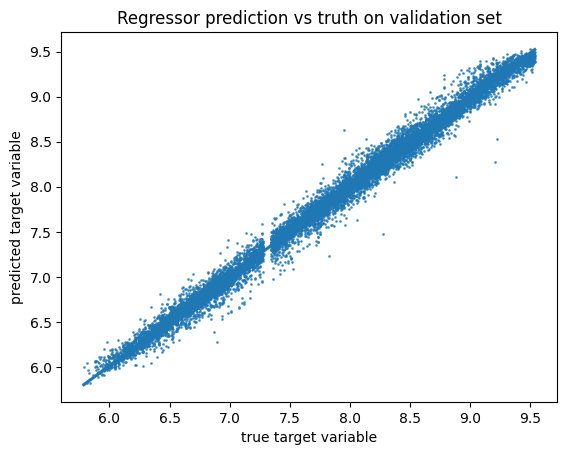

In [53]:
reg_perf(xgb, X_train, X_valid, y_train, y_valid)

In [54]:
def objective(trial, X_training, y_training, X_validation, y_validation):
    learning_rate_guess = trial.suggest_float("learning_rate", 1e-2, 2, log=True)
    max_depth_guess = trial.suggest_int("max_depth", 2, 50, log=False)
    reg_lambda_guess = trial.suggest_int("reg_lambda", 1, 50, log=False)
    n_estimators_guess = trial.suggest_int("n_estimators", 30, 150, log=False)
    
    xgb = XGBRegressor(
        n_estimators=n_estimators_guess,        
        learning_rate=learning_rate_guess,       
        max_depth=max_depth_guess,             
        min_child_weight=1,      
        gamma=0.0,               
        subsample=1.0,           
        colsample_bytree=1.0,   
        colsample_bylevel=1.0,   
        colsample_bynode=1.0,    
        reg_alpha=0.0,           
        reg_lambda=reg_lambda_guess,          
        tree_method="hist",      
        booster="gbtree",        
        objective="reg:squarederror",
        eval_metric=None,        
        early_stopping_rounds=None,  
        random_state=42,
        verbosity=1              
    )
    xgb.fit(X_training, y_training)
    
    y_pred_validation = xgb.predict(X_validation)
    r2_validation = metrics.r2_score(y_validation, y_pred_validation)
    return r2_validation

In [55]:
study = optuna.create_study(study_name="xgb", 
                            load_if_exists=True, 
                            storage = "sqlite:///opt.db",
                            direction="maximize")

study.optimize(lambda trial: objective(trial, X_train, y_train, X_valid, y_valid), n_trials=50, show_progress_bar=True)

[I 2025-12-07 12:45:42,205] A new study created in RDB with name: xgb


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-07 12:45:44,555] Trial 0 finished with value: 0.9917848706245422 and parameters: {'learning_rate': 0.3567535136798045, 'max_depth': 18, 'reg_lambda': 48, 'n_estimators': 78}. Best is trial 0 with value: 0.9917848706245422.
[I 2025-12-07 12:45:44,996] Trial 1 finished with value: 0.9926007390022278 and parameters: {'learning_rate': 0.17659364270565403, 'max_depth': 8, 'reg_lambda': 5, 'n_estimators': 121}. Best is trial 1 with value: 0.9926007390022278.
[I 2025-12-07 12:46:00,826] Trial 2 finished with value: 0.9900513291358948 and parameters: {'learning_rate': 0.02659979388159017, 'max_depth': 20, 'reg_lambda': 1, 'n_estimators': 125}. Best is trial 1 with value: 0.9926007390022278.
[I 2025-12-07 12:46:15,969] Trial 3 finished with value: 0.9811756014823914 and parameters: {'learning_rate': 1.5130988645288403, 'max_depth': 48, 'reg_lambda': 12, 'n_estimators': 51}. Best is trial 1 with value: 0.9926007390022278.
[I 2025-12-07 12:46:34,390] Trial 4 finished with value: 0.9915

In [57]:
study.best_params

{'learning_rate': 0.07773079333807685,
 'max_depth': 11,
 'reg_lambda': 7,
 'n_estimators': 139}

In [58]:
xgb = XGBRegressor(
    n_estimators=139,        
    learning_rate=0.07773079333807685,       
    max_depth=11,             
    min_child_weight=1,      
    gamma=0.0,               
    subsample=1.0,           
    colsample_bytree=1.0,   
    colsample_bylevel=1.0,   
    colsample_bynode=1.0,    
    reg_alpha=0.0,           
    reg_lambda=7,          
    tree_method="hist",      
    booster="gbtree",        
    objective="reg:squarederror",
    eval_metric=None,        
    early_stopping_rounds=None,  
    random_state=42,
    verbosity=1              
)

In [59]:
%time xgb.fit(X_train, y_train)

CPU times: total: 10.9 s
Wall time: 1.43 s


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=1.0, colsample_bynode=1.0, colsample_bytree=1.0,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.07773079333807685,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=11, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=139, n_jobs=None,
             num_parallel_tree=None, ...)

RMSE on training set : 0.051
RMSE on validation set : 0.081
R^2 on training set : 0.997
R^2 on validation set : 0.993


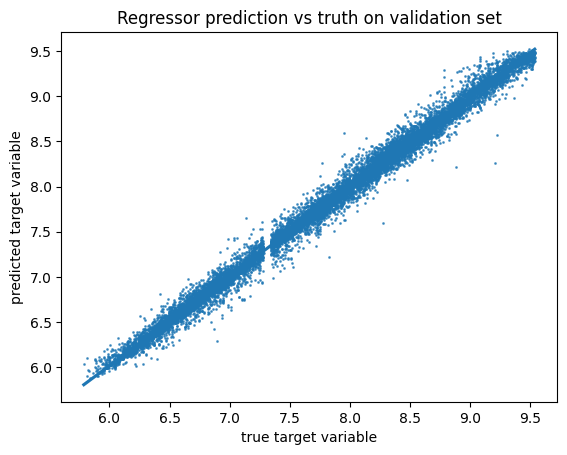

In [60]:
reg_perf(xgb, X_train, X_valid, y_train, y_valid)

## Model interpretation

### feature importance

In [64]:
xgb.feature_importances_

array([8.7751493e-02, 8.2993862e-04, 8.2432358e-03, 2.3265682e-02,
       3.1224193e-04, 2.9393949e-04, 2.6758906e-02, 7.9628450e-01,
       9.4589777e-04, 5.3716306e-02, 2.9666815e-04, 1.3011417e-03],
      dtype=float32)

In [65]:
xgb_feat_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb.feature_importances_
}).sort_values('importance', ascending=False)

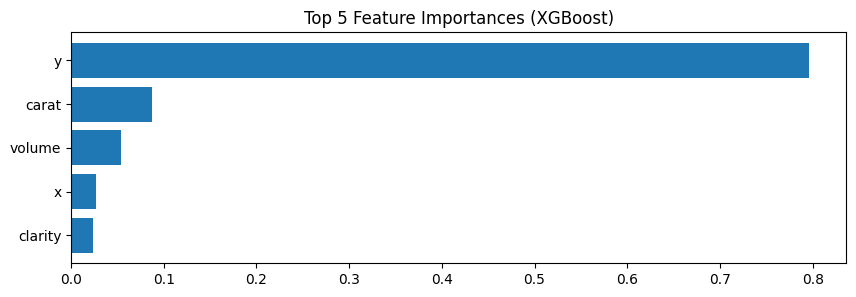

In [66]:
plt.figure(figsize=(10,3))
plt.barh(xgb_feat_importance['feature'][:5], xgb_feat_importance['importance'][:5])
plt.gca().invert_yaxis()
plt.title("Top 5 Feature Importances (XGBoost)")
plt.show()

### Permutation Importance

In [67]:
result = permutation_importance(
    xgb, 
    X_valid, 
    y_valid, 
    n_repeats = 10,
    random_state = 42,
    n_jobs = -1,
)
sorted_idx = result.importances_mean.argsort()

In [68]:
result

{'importances_mean': array([0.42010595, 0.0013759 , 0.04016489, 0.0899615 , 0.00058238,
        0.00042614, 0.03483127, 0.34134336, 0.00850689, 0.01990578,
        0.00070316, 0.00703769]),
 'importances_std': array([3.22757872e-03, 3.80616244e-05, 3.75035256e-04, 8.28132475e-04,
        3.96270672e-05, 3.07783548e-05, 2.96769189e-04, 3.69510907e-03,
        7.62084600e-05, 2.13807380e-04, 4.01391189e-05, 7.86132834e-05]),
 'importances': array([[4.20201957e-01, 4.23528850e-01, 4.22793925e-01, 4.14621651e-01,
         4.19728816e-01, 4.17253673e-01, 4.15180743e-01, 4.21362221e-01,
         4.24183965e-01, 4.22203720e-01],
        [1.38795376e-03, 1.43480301e-03, 1.43414736e-03, 1.41918659e-03,
         1.35463476e-03, 1.35779381e-03, 1.33174658e-03, 1.33973360e-03,
         1.35874748e-03, 1.34021044e-03],
        [3.97660732e-02, 4.06029820e-02, 3.97943258e-02, 4.08743024e-02,
         4.02067900e-02, 4.01969552e-02, 4.01377082e-02, 3.95773649e-02,
         4.00834084e-02, 4.04090285e

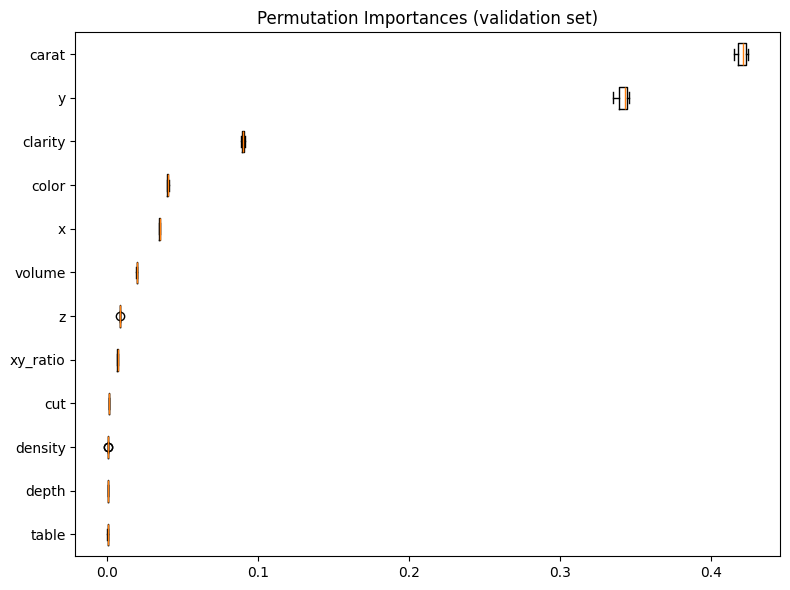

In [69]:
fig, ax = plt.subplots(figsize = (8, 6))
ax.boxplot(
    result.importances[sorted_idx].T,
    vert = False, 
    tick_labels = X_valid.columns[sorted_idx],
)
ax.set_title("Permutation Importances (validation set)")
fig.tight_layout()
plt.show()

### Feature correlations

In [70]:
cols = df.columns.tolist()

In [71]:
corr = np.round(scipy.stats.spearmanr(df[cols]).correlation, 4)
corr.size

144

C:\Users\13983\AppData\Local\Temp\ipykernel_27288\2058658202.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + cols)
C:\Users\13983\AppData\Local\Temp\ipykernel_27288\2058658202.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + cols)


[Text(0, -2.0, ''),
 Text(0, 0.0, 'carat'),
 Text(0, 2.0, 'cut'),
 Text(0, 4.0, 'color'),
 Text(0, 6.0, 'clarity'),
 Text(0, 8.0, 'depth'),
 Text(0, 10.0, 'table'),
 Text(0, 12.0, 'x')]

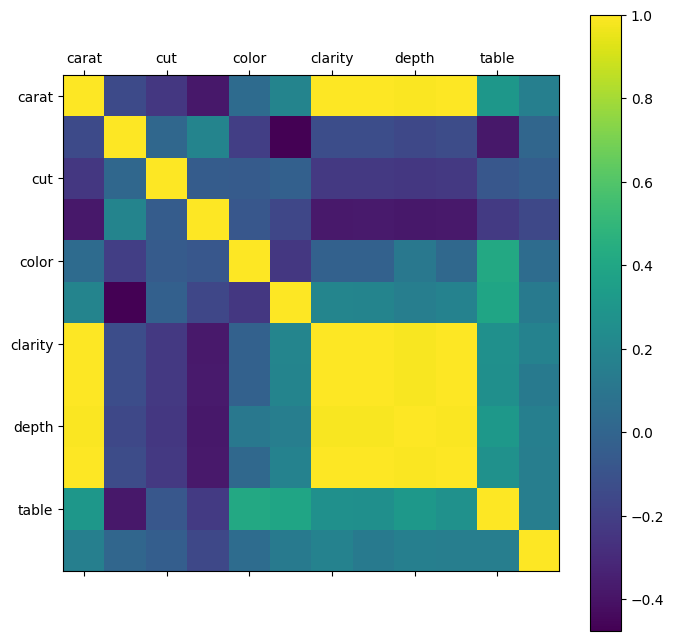

In [72]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(corr)
fig.colorbar(cax)
ax.set_xticklabels([''] + cols)
ax.set_yticklabels([''] + cols)

In [73]:
corr_condensed = hierarchy.distance.squareform(1 - corr)
corr_condensed.size

66

In [74]:
corr_linkage = hierarchy.linkage(corr_condensed, method = 'average')

In [75]:
corr_linkage

array([[0.00000000e+00, 9.00000000e+00, 1.80000000e-03, 2.00000000e+00],
       [6.00000000e+00, 7.00000000e+00, 2.30000000e-03, 2.00000000e+00],
       [1.20000000e+01, 1.30000000e+01, 3.07500000e-03, 4.00000000e+00],
       [8.00000000e+00, 1.40000000e+01, 9.57500000e-03, 5.00000000e+00],
       [4.00000000e+00, 1.00000000e+01, 5.85000000e-01, 2.00000000e+00],
       [1.00000000e+00, 3.00000000e+00, 8.10600000e-01, 2.00000000e+00],
       [5.00000000e+00, 1.50000000e+01, 8.18980000e-01, 6.00000000e+00],
       [1.10000000e+01, 1.80000000e+01, 8.49033333e-01, 7.00000000e+00],
       [1.60000000e+01, 1.90000000e+01, 8.65014286e-01, 9.00000000e+00],
       [2.00000000e+00, 1.70000000e+01, 1.01370000e+00, 3.00000000e+00],
       [2.00000000e+01, 2.10000000e+01, 1.20735185e+00, 1.20000000e+01]])

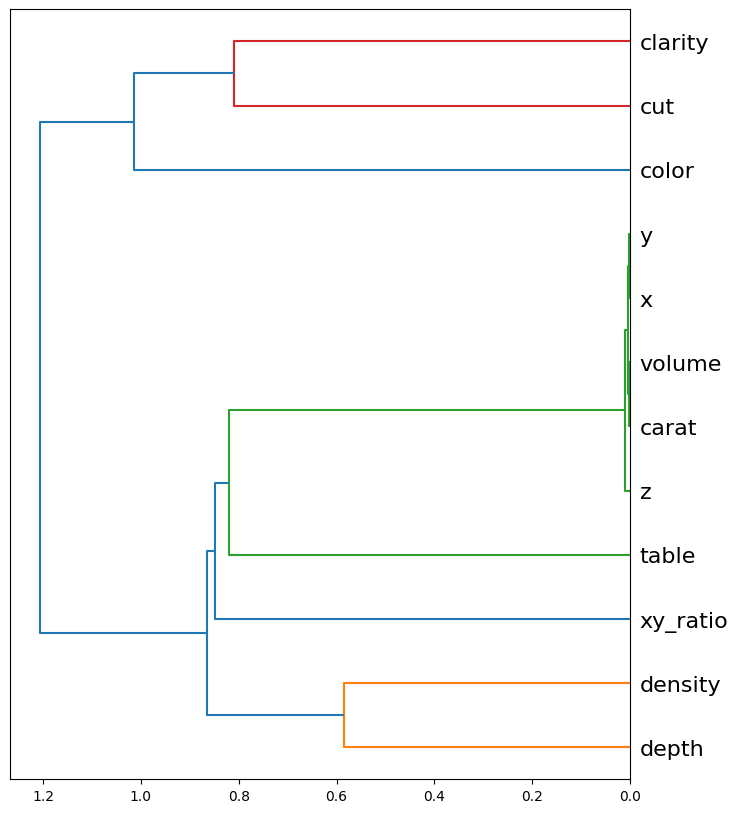

In [76]:
fig = plt.figure(figsize = (8,10))
dendrogram = hierarchy.dendrogram(
    corr_linkage, 
    labels = cols, 
    orientation = 'left', 
    leaf_font_size = 16,
)
plt.show()

In [77]:
%pip install shap
import shap

   ---------------------------------------- 0.0/548.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/548.0 kB ? eta -:--:--
   ------------------- -------------------- 262.1/548.0 kB ? eta -:--:--
   ---------------------------------------- 548.0/548.0 kB 1.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.7 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.7 MB 1.3 MB/s eta 0:00:02
   ----------- ---------------------------- 0.8/2.7 MB 1.5 MB/s eta 0:00:02
   ------------------- -------------------- 1.3/2.7 MB 1.7 MB/s eta 0:00:01
   ---------------------- ----------------- 1.6/2.7 MB 1.7 MB/s eta 0:00:01
   ---------------------------------- ----- 2.4/2.7 MB 1.9 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
    -------------------------------------

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.2.6 which is incompatible.
ecl-course-2024-t4 0.1.0 requires numpy==1.26.0, but you have numpy 2.2.6 which is incompatible.


In [78]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values, X_valid)

[autoreload of numpy.core failed: Traceback (most recent call last):
  File "c:\Users\13983\miniconda3\envs\ecl-course-2025\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\13983\miniconda3\envs\ecl-course-2025\Lib\site-packages\IPython\extensions\autoreload.py", line 455, in superreload
    if not append_obj(module, old_objects, name, obj):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\13983\miniconda3\envs\ecl-course-2025\Lib\site-packages\IPython\extensions\autoreload.py", line 423, in append_obj
    in_module = hasattr(obj, "__module__") and obj.__module__ == module.__name__
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\13983\miniconda3\envs\ecl-course-2025\Lib\site-packages\numpy\core\defchararray.py", line 2, in __getattr__
    from numpy._core import defchararray
  File "c:\Users\13983\miniconda3\envs\ecl-course-2025\Lib\site-packages\numpy\_core\defchararr

NameError: name '_wrapreduction' is not defined

In [ ]:
# 解释 X_valid 中的第 100 颗钻石的预测
diamond_index = 100 

# 注意：XGBoost 的输出已经是 NumPy 数组，直接用 shap_values 即可。
shap.waterfall(shap.Explanation(
    values=shap_values[diamond_index],
    base_values=explainer.expected_value,
    data=X_valid.iloc[diamond_index].values,
    feature_names=X_valid.columns.tolist()
), max_display=10)

In [ ]:
shap.dependence_plot("carat", shap_values, X_valid, interaction_index="color")

## Storage training model

In [79]:
import joblib
import os

In [80]:
joblib.dump(xgb, 'XGBoost_model.joblib')

['XGBoost_model.joblib']